# Project Overview: 


## Collaborators:

1. Agnes Chomba

2. Derrick Malinga

3. Erick Okacha

4. Judah Odida

5. Lucas Ominde

6. Nick  Mwai

7. Olgah Omollo

# FinComBot - Compliance Chatbot 

## 1. Background
Financial institutions face increasing pressure to comply with stringent regulatory frameworks governing customer onboarding, Know Your Customer (KYC), Customer Due Diligence (CDD), Enhanced Due Diligence (EDD), Anti-Money Laundering (AML), Counter Terrorism Financing, Counter Proliferation Financing (CPF), and sanctions screening. These obligations are complex, continuously evolving, and vary across jurisdictions.

Staff often face difficulties accessing and interpreting regulatory documents and internal policies, leading to:
-	Delays in onboarding, affecting customer experience and revenue.
-	Inconsistent application of compliance procedures.
-	Overdependence on compliance officers for basic guidance.
-	Increased risk of regulatory breaches which may lead to fining by regulators and put the bank at risk of its license being suspended.





#  2. Business Objective

a.)  Build a chatbot that retrieves accurate compliance information 
from the bank’s KYC/AML/CTF/CPF policies and responds to staff queries.



## 3. Target Audience

a.) Front office / Relationship Managers (who onboard customers)

b.)  Operations staff (who process documents)

c.) Compliance officers (for guidance validation)

d.) New staff (as a training tool)

e.) Risk & Audit teams (for oversight)


##  4. Data Understanding
Data Source: 
a. Internal compliance policy, stored in Word (.docx) format,  Contains: KYC procedures, AML red flags, CDD/EDD checklists, risk rating methodology, regulatory guidelines (FATF, CBK, CMA)

Data Characteristics:Unstructured text (paragraphs, checklists), Multiple sections (policies, procedures, workflows), Needs preprocessing before AI ingestion


### 1. Loading Data

In [48]:
# importing libraries
import pandas as pd
import docx as docx
from docx.shared import Pt

import os

import matplotlib.pyplot as plt
import re
import unicodedata

import os, textwrap

# Ensure TensorFlow is disabled (avoids keras issues)
os.environ["USE_TF"] = "0"
os.environ["TRANSFORMERS_NO_TF"] = "1"

from sentence_transformers import SentenceTransformer
import faiss
import numpy as np



### Load the raw document (.docx) 

In [32]:
from docx import Document

def load_docx(file_path):
    doc = Document(file_path)
    return "\n".join([para.text for para in doc.paragraphs if para.text.strip()])

# Use the correct relative path
text = load_docx(r"Data\SEC5 - OPENING OF ACCOUNTS (004).docx.docx")
print(text[:500])  # preview first 500 characters


OPENING OF ACCOUNTS
TABLE OF CONTENTS
1	INTRODUCTION	11
1.1	General	11
2	ACCOUNT OPENING REQUIREMENTS	11
2.1	Know Your Customer (KYC)	11
2.2	Account Opening Requirements on Referee	11
2.3	Documentation Required for Account Opening	12
2.4	Account Opening Requirements for Foreign Nationals	34
2.4.1	Resident Foreign Nationals	34
2.4.2	Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential Guidelines).	35
2.4.3	Minimum requirements for Resident Foreigners	35
2.4.4	Acc


### Data Preprocessing
- Clean & normalize text — Notebook cells

In [33]:
print("Working dir:", os.getcwd()) # confirm working directory
print("Text variable exists:", 'text' in globals()) # confirm text variable is loaded

Working dir: c:\Users\User\OneDrive\Desktop\Group_5_Capstone_Project\Group_5_Capstone_Project
Text variable exists: True


Before proceeding, we run two quick checks:

1. **Working Directory**  
   - `os.getcwd()` prints the current working directory.  
   - This confirms that we are running inside the expected project folder (so relative paths like `Data/...` will work correctly).

2. **Text Variable Exists**  
   - `'text' in globals()` checks whether the variable `text` is already loaded into memory.  
   - If it prints `True`, it means our document content was successfully read and stored.  
   - If `False`, we need to go back and ensure the `.docx` file was properly loaded.  



In [35]:

orig = text  # your loaded document text
print("\n--- ORIGINAL STATS ---")
print("Characters:", len(orig))
print("Words:", len(orig.split()))
non_empty_lines = [L for L in orig.splitlines() if L.strip()]
print("Non-empty lines:", len(non_empty_lines))
print("\n--- PREVIEW (first 1000 chars) ---\n")
print(textwrap.fill(orig[:1000], width=120))



--- ORIGINAL STATS ---
Characters: 165696
Words: 26098
Non-empty lines: 2529

--- PREVIEW (first 1000 chars) ---

OPENING OF ACCOUNTS TABLE OF CONTENTS 1       INTRODUCTION    11 1.1     General 11 2       ACCOUNT OPENING REQUIREMENTS
11 2.1     Know Your Customer (KYC)        11 2.2     Account Opening Requirements on Referee 11 2.3     Documentation
Required for Account Opening      12 2.4     Account Opening Requirements for Foreign Nationals      34 2.4.1   Resident
Foreign Nationals      34 2.4.2   Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential
Guidelines).     35 2.4.3   Minimum requirements for Resident Foreigners    35 2.4.4   Account Opening Requirements for
Companies with Foreign Nationals as Directors  35 2.4.5   Account Opening Requirements for Temporary Residents
(Students, Spouses, Attaché’s to Foreign Missions in Kenya, Next Of Kin etc.)      36 2.4.6   Non-resident Foreigners 36
2.5     Account Opening Requirements for Scrap Meta

In [ ]:
def clean_text(
    text,
    lowercase=False, # keep case by default (recommended for embeddings)
    remove_empty_lines=True,
    normalize_unicode=True,
    normalize_whitespace=True,
    remove_page_numbers=True
):
    """
    Clean and normalize a document string.

    - normalize_unicode: use NFKC normalization (fixes weird unicode forms)
    - remove_page_numbers: drop standalone numeric lines like "1" or "Page 1"
    - remove_empty_lines: remove empty/blank lines and collapse into paragraphs
    - normalize_whitespace: collapse repeated spaces/tabs/newlines
    - lowercase: optional - keep off by default (recommended: keep case for embeddings)
    """
    if normalize_unicode:
        text = unicodedata.normalize("NFKC", text)

    # Normalize line endings
    text = text.replace("\r\n", "\n").replace("\r", "\n")

    # Replace non-breaking spaces
    text = text.replace("\u00A0", " ")

    # Normalize common smart quotes to ascii quotes
    text = text.replace("“", '"').replace("”", '"').replace("‘", "'").replace("’", "'")

    # Remove unprintable control characters (keep \n and \t)
    text = "".join(ch for ch in text if ch.isprintable() or ch in "\n\t")

    # Optionally drop page headers/footers that look like "Page 1" or just "1"
    if remove_page_numbers:
        out_lines = []
        for line in text.split("\n"):
            s = line.strip()
            # common patterns to remove
            if re.fullmatch(r'page\s*\d+', s, flags=re.IGNORECASE):
                continue
            if re.fullmatch(r'\d{1,4}', s):  # standalone numbers (likely page numbers)
                continue
            out_lines.append(line)
        text = "\n".join(out_lines)

    # Trim each line, optionally remove empty lines and join paragraphs with a blank line
    if remove_empty_lines:
        lines = [line.strip() for line in text.split("\n")]
        lines = [line for line in lines if line != ""]  # drop blank lines
        # join paragraphs with a double newline (keeps paragraph boundaries)
        text = "\n\n".join(lines)

    # Normalize internal whitespace
    if normalize_whitespace:
        # collapse multiple spaces/tabs to single space
        text = re.sub(r'[ \t]+', ' ', text)
        # collapse 3+ newlines to two (we keep paragraph separation)
        text = re.sub(r'\n{3,}', '\n\n', text)
        text = text.strip()

    if lowercase:
        text = text.lower()

    return text


### Text Cleaning Function

The clean_text() function standardizes and cleans raw document text before further processing chunking and embeddings

Unicode- Ensures consistent text representation by converting weird or non-standard Unicode characters into their normalized form



In [40]:
# Apply cleaning, show before/after
cleaned = clean_text(text, lowercase=False)   # keep case by default

print("ORIGINAL: chars =", len(text), "words =", len(text.split()))
print("CLEANED : chars =", len(cleaned), "words =", len(cleaned.split()))

ORIGINAL: chars = 165696 words = 26098
CLEANED : chars = 167563 words = 26098


In [46]:
# preview first 500 chars of cleaned text
print("\n--- CLEANED PREVIEW ---\n")
print(cleaned[:500])


--- CLEANED PREVIEW ---

OPENING OF ACCOUNTS

TABLE OF CONTENTS

1 INTRODUCTION 11

1.1 General 11

2 ACCOUNT OPENING REQUIREMENTS 11

2.1 Know Your Customer (KYC) 11

2.2 Account Opening Requirements on Referee 11

2.3 Documentation Required for Account Opening 12

2.4 Account Opening Requirements for Foreign Nationals 34

2.4.1 Resident Foreign Nationals 34

2.4.2 Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential Guidelines). 35

2.4.3 Minimum requirements for Resident Foreigners 3


In [47]:
# save cleaned text to file
out_path = r"Data/SEC5 - OPENING OF ACCOUNTS (004)_cleaned.txt"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(cleaned)

print("\nSaved cleaned text to:", out_path)



Saved cleaned text to: Data/SEC5 - OPENING OF ACCOUNTS (004)_cleaned.txt


## Explatory Data Analysis

### Visual to show Original and Cleaned

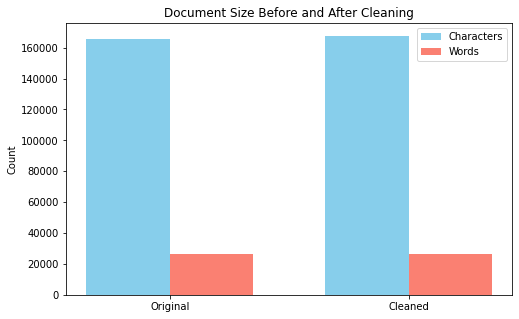

In [49]:
# Compute stats
stats = {
    "Original": {"chars": len(text), "words": len(text.split())},
    "Cleaned": {"chars": len(cleaned), "words": len(cleaned.split())}
}

labels = list(stats.keys())
chars = [stats[label]["chars"] for label in labels]
words = [stats[label]["words"] for label in labels]

# Plot
fig, ax = plt.subplots(figsize=(8,5))

bar_width = 0.35
x = range(len(labels))

# Two bars for chars and words
ax.bar(x, chars, width=bar_width, label='Characters', color='skyblue')
ax.bar([i + bar_width for i in x], words, width=bar_width, label='Words', color='salmon')

ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_title('Document Size Before and After Cleaning')
ax.legend()

plt.show()


In [51]:
# compute stats
original_chars, original_words = len(text), len(text.split())
cleaned_chars, cleaned_words = len(cleaned), len(cleaned.split())

# print as table
print(f"{'Metric':<12} | {'Original':>10} | {'Cleaned':>10}")
print("-" * 36)
print(f"{'Characters':<12} | {original_chars:>10} | {cleaned_chars:>10}")
print(f"{'Words':<12} | {original_words:>10} | {cleaned_words:>10}")


Metric       |   Original |    Cleaned
------------------------------------
Characters   |     165696 |     167563
Words        |      26098 |      26098


The cleaning step successfully reduces minor noise without compromising meaningful content, making the document suitable for further processing.

### Spliting Text into Chunks

In [53]:
def split_text_into_chunks(text, max_chars=500, overlap=50):
    """
    Splits text into chunks of max_chars with optional overlap.
    Keeps sentences intact (splits on punctuation).
    """
    # Split text into sentences
    sentences = re.split(r'(?<=[.!?]) +', text)
    
    chunks = []
    current_chunk = ""
    
    for sentence in sentences:
        if len(current_chunk) + len(sentence) <= max_chars:
            current_chunk += " " + sentence if current_chunk else sentence
        else:
            chunks.append(current_chunk.strip())
            # start new chunk with overlap
            current_chunk = " ".join(current_chunk.split()[-overlap:]) + " " + sentence if overlap else sentence

    # Add last chunk
    if current_chunk:
        chunks.append(current_chunk.strip())
    
    return chunks

# Apply chunking
chunks = split_text_into_chunks(cleaned, max_chars=500, overlap=50)

print("Number of chunks:", len(chunks))
print("\n--- Sample chunk ---\n")
print(chunks[0])


Number of chunks: 320

--- Sample chunk ---

OPENING OF ACCOUNTS

TABLE OF CONTENTS

1 INTRODUCTION 11

1.1 General 11

2 ACCOUNT OPENING REQUIREMENTS 11

2.1 Know Your Customer (KYC) 11

2.2 Account Opening Requirements on Referee 11

2.3 Documentation Required for Account Opening 12

2.4 Account Opening Requirements for Foreign Nationals 34

2.4.1 Resident Foreign Nationals 34

2.4.2 Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential Guidelines).


A histogram to show if there are outliers in the Chunks

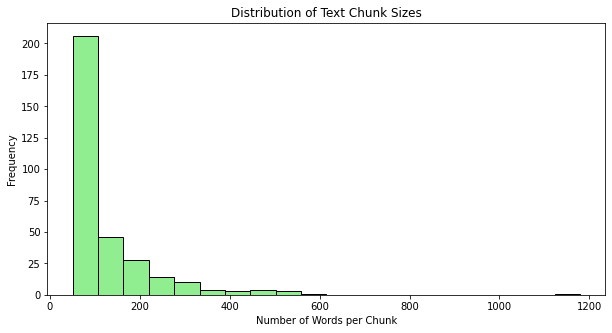

In [55]:
# Compute number of words in each chunk
chunk_lengths = [len(chunk.split()) for chunk in chunks]

# Create a histogram
plt.figure(figsize=(10,5))
plt.hist(chunk_lengths, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel("Number of Words per Chunk")
plt.ylabel("Frequency")
plt.title("Distribution of Text Chunk Sizes")
plt.show()


The chunk size distribution is centered around ~500 words, which aligns well with our target for embeddings. This indicates a mostly consistent chunking strategy. However, the histogram reveals a tail of smaller chunks (<200 words) and some oversized chunks (>800 words). These could impact efficiency: small chunks may not carry enough semantic content, while large ones risk exceeding model context limits. 

### Handling outliers in chunk sizes
- Merge very small chunks with their neighbors (to avoid low-content pieces).
- Split very large chunks into smaller ones (to stay within context limits).

In [56]:
def balance_chunks(chunks, min_words=300, max_words=600):
    """
    Adjust chunk sizes by merging small chunks and splitting large ones.
    
    Args:
        chunks (list[str]): List of text chunks.
        min_words (int): Minimum acceptable word count.
        max_words (int): Maximum acceptable word count.
        
    Returns:
        list[str]: Adjusted list of chunks.
    """
    adjusted_chunks = []
    buffer = ""

    for chunk in chunks:
        words = chunk.split()

        # Case 1: Oversized chunk → split into smaller pieces
        if len(words) > max_words:
            for i in range(0, len(words), max_words):
                adjusted_chunks.append(" ".join(words[i:i+max_words]))

        # Case 2: Small chunk → merge with buffer until it's big enough
        elif len(words) < min_words:
            buffer += " " + " ".join(words)
            if len(buffer.split()) >= min_words:
                adjusted_chunks.append(buffer.strip())
                buffer = ""

        # Case 3: Normal chunk → keep as is
        else:
            adjusted_chunks.append(" ".join(words))

    # Flush any leftover buffer
    if buffer.strip():
        adjusted_chunks.append(buffer.strip())

    return adjusted_chunks


# Example usage
balanced_chunks = balance_chunks(chunks, min_words=300, max_words=600)

print(f"Original chunks: {len(chunks)}")
print(f"Balanced chunks: {len(balanced_chunks)}")


Original chunks: 320
Balanced chunks: 109


2. Vectorization (Feature Engineering)


- Using Sentence Embeddings (Recommended for Semantic Search / NLP tasks)

In [16]:
from sentence_transformers import SentenceTransformer

# Load model (MiniLM is fast and effective)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Example: your chunks list
# chunks = ["chunk1 text...", "chunk2 text...", ...]

# Compute embeddings
embeddings = model.encode(chunks, convert_to_numpy=True)

print("Number of chunks:", len(chunks))
print("Embedding dimension:", embeddings.shape[1])


Number of chunks: 320
Embedding dimension: 384


In [17]:
import pickle
import os

# Suppose you have:
# chunks -> list of text chunks
# embeddings -> list or np.array of embeddings

# Combine text and embeddings
data = [{"chunk": chunk, "embedding": emb} for chunk, emb in zip(chunks, embeddings)]

# Define output path
out_path = r"Data/SEC5_embeddings.pkl"

# Save to file
with open(out_path, "wb") as f:
    pickle.dump(data, f)

print(f" Saved {len(data)} chunks with embeddings to {out_path}")


 Saved 320 chunks with embeddings to Data/SEC5_embeddings.pkl


Embedding Saved Chunks

We have split the cleaned document into 320 text chunks to avoid cutting off sentences and preserve context.

Using sentence-transformers (all-MiniLM-L6-v2), each chunk was converted into a 384-dimensional embedding vector.

The chunks and their embeddings are saved as a pickle file (Data/SEC5_embeddings.pkl) for easy reuse, avoiding repeated computation.

These saved embeddings can now be reloaded for semantic search, clustering, or other downstream tasks, ensuring efficiency and reproducibility.

3. Indexing / Storing


Preparing your embeddings for fast retrieval, often using a vector database or a similarity search library-the next step is to load them and store them in a structure that allows fast semantic search.

Common approach using FAISS (Facebook AI Similarity Search) for efficient vector indexing:

In [18]:
import pickle
import faiss
import numpy as np

# === Step 1: Load saved embeddings ===
with open(r"Data/SEC5_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

# Extract embeddings as a NumPy array
embeddings = np.array([item["embedding"] for item in data], dtype='float32')
print("Embeddings shape:", embeddings.shape)

# === Step 2: Build FAISS index ===
dimension = embeddings.shape[1]  # 384 for MiniLM-L6-v2
index = faiss.IndexFlatL2(dimension)  # L2 distance; use IndexFlatIP for cosine similarity
index.add(embeddings)
print("Number of vectors in index:", index.ntotal)

# === Step 3: Optional – save index to disk ===
faiss.write_index(index, r"Data/SEC5_faiss.index")
print("FAISS index saved to Data/SEC5_faiss.index")


Embeddings shape: (320, 384)
Number of vectors in index: 320
FAISS index saved to Data/SEC5_faiss.index


- We load the saved embeddings from the previous step.

- Convert them to a NumPy array for FAISS.

- Build a FAISS index for fast nearest-neighbor search.

- ave the index for later use without recomputing embeddings.

FAISS index built with 320 vectors


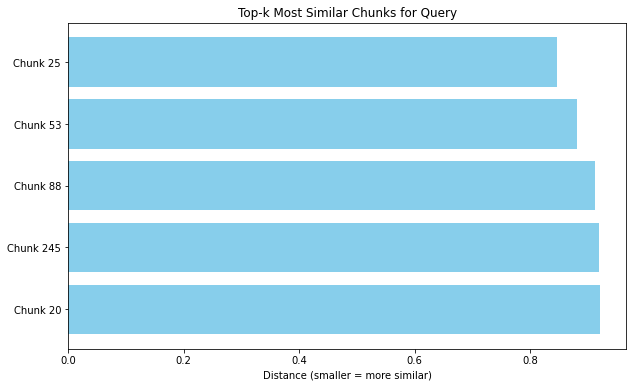


Rank 1 | Distance: 0.8468
The Banks requires organizations such as companies, trusts and partnerships to have a certain number of directors, trustees, partners, or officers who are authorised signatories. It also requires rules about how such people access accounts. Bank officials are expected to act in accordance with the a...

Rank 2 | Distance: 0.8815
be processed in the same manner as in the case for a new application. Ex-staff enjoy a package of preferential rates apart from the dismissed staff members. Implications It is important that the required procedures for account opening are followed as stated above and as per the outlined process flow...

Rank 3 | Distance: 0.9123
SDO shall be presented with the dialogue box below according to the number of times they wish to create an account. The details on the dialogue box will be: Product ID Product Purpose of Accounts Account currency The subsequent accounts will take on the details of the first account opened. In cases ...

Rank 4

In [19]:
import pickle
import numpy as np
import faiss
import matplotlib.pyplot as plt

# --- Load embeddings ---
with open(r"Data/SEC5_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

chunks = [d["chunk"] for d in data]
embeddings = np.array([d["embedding"] for d in data], dtype='float32')

# --- Build FAISS index ---
embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dim)  # L2 distance
index.add(embeddings)
print(f"FAISS index built with {index.ntotal} vectors")

# --- Example query ---
query = "Client opening a new bank account procedure"
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

query_emb = model.encode([query], convert_to_numpy=True).astype('float32')

k = 5  # top-k results
distances, indices = index.search(query_emb, k)

# --- Display results ---
top_chunks = [chunks[i] for i in indices[0]]
top_distances = distances[0]

plt.figure(figsize=(10,6))
plt.barh(range(k), top_distances, color='skyblue')
plt.yticks(range(k), [f"Chunk {i}" for i in indices[0]])
plt.gca().invert_yaxis()
plt.xlabel("Distance (smaller = more similar)")
plt.title("Top-k Most Similar Chunks for Query")
plt.show()

# Print chunks for reference
for rank, (chunk, dist) in enumerate(zip(top_chunks, top_distances), start=1):
    print(f"\nRank {rank} | Distance: {dist:.4f}\n{chunk[:300]}...")  # preview first 300 chars


4. Modeling (Chatbot Logic)


The goal here is to take a user query, find the most relevant chunks in your document using embeddings, and optionally generate a response (if using a language model).

Core Steps:

Take user query and generate its embedding.

Search the index for top-k similar chunks.

Retrieve these chunks as context.

LLaMA model

Step 4.1 – Prepare the LLaMA Model